En este notebook la diferencia que hay con respecto al anterior es que estamos haciendo uso del optimizador que usa el artículo de voets, con los parámetros que usan en dicho artículo, aunque manteniendo la misma función de error de los anteriores notebooks, ya que la función de error del artículo de voets está diseñada para una salida sigmoide de la red.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

In [2]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join(base_dir, 'train5k_5cat')
test_dir = os.path.join( base_dir,'test1k_5cat')


In [3]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
train_2 = os.path.join(train_dir, '2') 
train_3 = os.path.join(train_dir, '3')  
train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
val_2 = os.path.join(val_dir, '2') 
val_3 = os.path.join(val_dir, '3')  
val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
num_2_tr = len(os.listdir(train_2))
num_3_tr = len(os.listdir(train_3))
num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
num_2_v = len(os.listdir(val_2))
num_3_v = len(os.listdir(val_3))
num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr + num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v + num_2_v + num_3_v + num_4_v
 

In [4]:

def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float32)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float32)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

def augment_pre(image):
    
    augmentation=True
    
    BRIGHTNESS_MAX_DELTA = 0.125
    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5
    HUE_MAX_DELTA = 0.2
    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    image = rescale_min_1_to_1(image)

    # Apply data augmentations randomly.
    augmentations = [
        {'fn': tf.image.random_flip_left_right},
        {'fn': tf.image.random_brightness,
         'args': [BRIGHTNESS_MAX_DELTA]},
        {'fn': tf.image.random_saturation,
         'args': [SATURATION_LOWER, SATURATION_UPPER]},
        {'fn': tf.image.random_hue,
         'args': [HUE_MAX_DELTA]},
        {'fn': tf.image.random_contrast,
         'args': [CONTRAST_LOWER, CONTRAST_UPPER]}]

    shuffle(augmentations)

    if augmentation:
        for aug in augmentations:
            if 'args' in aug:
                image = aug['fn'](image, *aug['args'])
            else:
                image = aug['fn'](image)
    return image

In [5]:
img_height=299
img_width=299
batch_size=32


In [6]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='sparse'
                                                     )

Found 2129 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


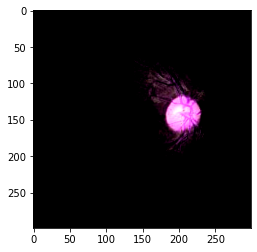

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


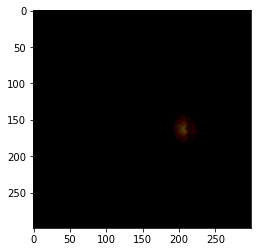

In [7]:

x,y= train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [8]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='sparse'
                                                  )

Found 377 images belonging to 5 classes.


In [9]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(299, 299, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5,activation='softmax')
    ])
    
    



    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-3,decay=4e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [10]:
with tf.device('/GPU:0'):
    epochs=200
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size)))
    )

Train for 67 steps, validate for 12 steps
Epoch 1/200
67/67 [==============================] - 28s 423ms/step - loss: 1.5383 - accuracy: 0.3664 - val_loss: 1.5605 - val_accuracy: 0.3448
Epoch 2/200
67/67 [==============================] - 25s 374ms/step - loss: 1.5349 - accuracy: 0.3697 - val_loss: 1.5605 - val_accuracy: 0.3448
Epoch 3/200
67/67 [==============================] - 26s 381ms/step - loss: 1.5351 - accuracy: 0.3697 - val_loss: 1.5605 - val_accuracy: 0.3448
Epoch 4/200
67/67 [==============================] - 25s 372ms/step - loss: 1.5318 - accuracy: 0.3701 - val_loss: 1.5048 - val_accuracy: 0.3448
Epoch 5/200
67/67 [==============================] - 25s 373ms/step - loss: 1.4747 - accuracy: 0.3870 - val_loss: 1.4966 - val_accuracy: 0.3528
Epoch 6/200
67/67 [==============================] - 25s 373ms/step - loss: 1.4704 - accuracy: 0.3744 - val_loss: 1.4872 - val_accuracy: 0.3607
Epoch 7/200
67/67 [==============================] - 25s 376ms/step - loss: 1.4661 - accuracy:

67/67 [==============================] - 25s 369ms/step - loss: 1.1745 - accuracy: 0.7276 - val_loss: 1.5452 - val_accuracy: 0.3528
Epoch 114/200
67/67 [==============================] - 25s 368ms/step - loss: 1.1616 - accuracy: 0.7417 - val_loss: 1.5639 - val_accuracy: 0.3342
Epoch 115/200
67/67 [==============================] - 25s 366ms/step - loss: 1.1567 - accuracy: 0.7450 - val_loss: 1.5664 - val_accuracy: 0.3236
Epoch 116/200
67/67 [==============================] - 25s 370ms/step - loss: 1.1580 - accuracy: 0.7482 - val_loss: 1.5517 - val_accuracy: 0.3501
Epoch 117/200
67/67 [==============================] - 25s 369ms/step - loss: 1.1582 - accuracy: 0.7468 - val_loss: 1.5591 - val_accuracy: 0.3395
Epoch 118/200
67/67 [==============================] - 25s 368ms/step - loss: 1.1539 - accuracy: 0.7492 - val_loss: 1.5609 - val_accuracy: 0.3395
Epoch 119/200
67/67 [==============================] - 25s 371ms/step - loss: 1.1455 - accuracy: 0.7576 - val_loss: 1.5333 - val_accuracy:

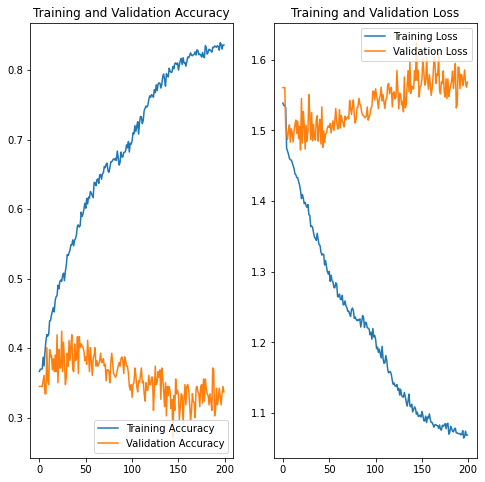

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Mantenemos resultados nefastos para el set de validación, aunque el nuevo optimizador con los nuevos parámetros proporciona un aprendizaje más rápido en el set de entrenamiento.

In [9]:
# Guardar el Modelo
model.save('miniprueba2.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')